# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [246]:
#!pip install lightgbm

In [247]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import time

from sklearn import preprocessing
'''
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.svm import SVC'''
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,r2_score,roc_curve,f1_score,\
mean_squared_error,roc_auc_score,recall_score,precision_score,make_scorer,precision_recall_curve
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,LinearRegression,Ridge,RidgeCV,LassoCV,Ridge,Lasso
'''
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OrdinalEncoder
from sklearn import model_selection, svm
from sklearn.utils import resample
'''


from lightgbm import LGBMRegressor
#import lightgbm
from catboost import CatBoostRegressor, Pool
import xgboost as xgb


# random state
RNS = 0

In [248]:
#print(lightgbm.__version__)

In [249]:
# 2 варианта чтобы открыть файл:
try:
    cars = pd.read_csv('/datasets/autos.csv')
except:
    cars = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [250]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [251]:
#функция дает первичное представление об исходных данных: типы данных,количество пропусков,кол-во дубликатов,
#хар-ки числовых столбцов 
def df_info(df):
    print(80*"+")
    #print(f'Название таблицы : {df.name}')
    #print(80*"+")
    df.info()
    print(80*"+")
    print('Описание количественных переменных:')
    print(df.describe(percentiles=[.25,.5]))
    print(80*"+")
    print(f'количество дубликатов в таблице = {df.duplicated().sum()}')

In [252]:
df_info(cars)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [253]:
cars.NumberOfPictures.value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

### Заключения по результатам подготовки данных:
1. **Пропуски:**
    - колонки VehicleType, Gearbox,Model,FuelType,Brand можно попробовать заполнить по медианой по аналогам 
    - колонка NotRepaired возможно попробовать заполнить на основании RegistrationYear,Model,Price
2. **Анализ численных данных на адекватность:**
    - Price = 0 .Т.к. это таргет, то просто удалим этим строки, цена быть должна;
    - RegistrationYear надо отсечь/заполнить данные по годам >= 1875 и <= 04.2016 [ссылка][Year]
    - Power <= 1521 по состоянию на 2016 год [ссылка][Power]
    - Kilometer странно что медиана совпадает с max, проверить
    - RegistrationMonth >= 1, 0 быть не должно
    - NumberOfPictures везде 0. Отставим без изменений. ~~Придется удалить, т.к. не восстановить данные и вероятно значимость данного признака изначально была не высока~~
    - PostalCode: минимальное значение [существует][PostalCode_min]  и максимальное [тоже][PostalCode_max]
    
[Year]: https://www.hotcars.com/the-20-oldest-cars-in-the-world-and-they-still-work/

[Power]: https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output

[PostalCode_min]: https://postal-codes.cybo.com/netherlands/1067_amsterdam/
[PostalCode_max]: https://postal-codes.cybo.com/germany/99998_k%C3%B6rner-germany/


3. Анализ остальных колонок:
    - колонки DateCrawled,DateCreated,LastSeen не будут использованы при построении модели, т.к.не несут полезной информации. Т.е. будут удалены.
4. Выявлено **4 дубликата**, но скорее всего это полное совпадение, что реально. посмотрим на дубликаты, после того как сделаем upgrade данных

5. **Типы данных:**
    - колонки DateCrawled,DateCreated,LastSeen можно перевести в тип данных date, для анализа,но дальше будут удалены.
    - остальные колонки соответствуют своему типу
  
    
    
Алгоритм обработки данных:
- удалить колонку NumberOfPictures;
- изменить типы данных;
- работа с выбросами в численных данных;
- работа с пропусками;
- проверка на дубликаты;
- проверить через функцию df_info(cars)

~~#### Удаляем столбце NumberOfPictures, т.к. везде 0~~

In [254]:
# сделаем копию на будущее
cars2 = cars.copy()

In [255]:
#cars = cars.drop('NumberOfPictures',axis = 1)
#cars.head()

#### данные с типом datetime

In [256]:
cars[["DateCrawled", "DateCreated", "LastSeen"]] = cars[["DateCrawled", "DateCreated", "LastSeen"]].apply(pd.to_datetime)
cars['DateCrawled'].sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
176823   2016-03-05 14:06:24
99885    2016-03-05 14:06:24
324763   2016-03-05 14:06:24
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: DateCrawled, Length: 354369, dtype: datetime64[ns]

Данные выкачивали из базы с 5 марта 2016 по 7 апреля 2016, т.е. чуть больше месяца

In [257]:
cars['DateCreated'].sort_values()


61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
134418   2016-04-07
176987   2016-04-07
206303   2016-04-07
309336   2016-04-07
305430   2016-04-07
Name: DateCreated, Length: 354369, dtype: datetime64[ns]

In [258]:
pd.DatetimeIndex(cars['DateCreated']).year.value_counts()

2016    354343
2015        25
2014         1
Name: DateCreated, dtype: int64

Даты создания объявлений с 10 апреля 2014 по 7 апреля 2016 , т.е почти 2 года, но только 26 строк из 2014-2015 гг, а 354343 из 2016 года. Возможно до 2016 года сервис не был публичным, использовался для теста

In [259]:
pd.DatetimeIndex(cars.query('DateCreated>2016')['DateCreated']).month.value_counts()

3    296757
4     57119
2       397
1        70
Name: DateCreated, dtype: int64

Для 2016 года все данные созданы с января по апрель, все корректно

In [260]:
cars['LastSeen'].sort_values()

296785   2016-03-05 14:15:08
262341   2016-03-05 14:15:16
130462   2016-03-05 14:15:39
285695   2016-03-05 14:18:30
169065   2016-03-05 14:25:59
                 ...        
54852    2016-04-07 14:58:50
59506    2016-04-07 14:58:50
116344   2016-04-07 14:58:50
215705   2016-04-07 14:58:50
327303   2016-04-07 14:58:51
Name: LastSeen, Length: 354369, dtype: datetime64[ns]

#### Дата регистрации авто

Данные по активности пользователей говорят нам что самая ранняя была 5 марта 2016, самая поздняя 7 апреля 2016.

В целом столбцами где тип данных datetime все корректно.

Считаем, что регистрации автомобилей позже апреля 2016 и ранее 1875 года быть не должно.

Проверяем:


In [261]:
def part_of_value(df1,df):
    '''
    функция высчитывает % данных по определенному условию от полного размера
    '''
    return df1.shape[0]/df.shape[0]*100

In [262]:
def pass_value(df):
    '''
    функция высчитывает процент пропусков в df
    '''
    return df.isna().sum()/df.shape[0]*100

In [263]:
def pass_replace_3(df,col1,col2,col3,col,index):
    '''
    функция заменяет в исходном df значения на медианные предварительно группирую по 3 параметрам
    '''
    tmp = df.groupby([col1,col2,col3])[col].apply(lambda x: x.fillna(x.median()))
    df.loc[index,col] = tmp[index]
    return df

In [264]:
part_of_value(df1 = cars.query('(RegistrationYear>2016 or (RegistrationYear == 2016 and RegistrationMonth>4) or RegistrationYear<1875)'),
              df=cars)


5.4423496411932195

In [265]:
part_of_value(df1 = cars.query('RegistrationYear<1875'),
              df=cars)

0.01862465396239513

таких данных больше 5,4%. ~~удаляем.~~

Посмотрим по отдельности:  
- до 1875 года около 0,018%
- после апреля 2016 года около 5,4%


Т.к. временные ряды мы еще не проходили, и делить данные на трейн/тест будем случайным образом, поэтому
нет смысла удалять данные после апреля 2016 год, т.к. скорее всего это реальные данные с большим количеством полезной информации, а вот данные до 1875 года, можно удалить. Скорее всего это ошибка ввода.  
Таких данных немного.

In [266]:
cars = cars.drop(cars.query('RegistrationYear<1875').index)
cars.shape

(354303, 16)

In [267]:
#cars = cars.drop(cars.query('(RegistrationYear>2016 or (RegistrationYear == 2016 and RegistrationMonth>4) or RegistrationYear<1875)').index)
#cars.shape

#### столбец Price(таргет)

Медиана в районе 2500 , среднее выше 4576 и очень много цен в районе 0.
Цена не может быть равной 0. Подбирать/заполнять таргет - плохая идея, поэтому будем удалять

4417.210734879468

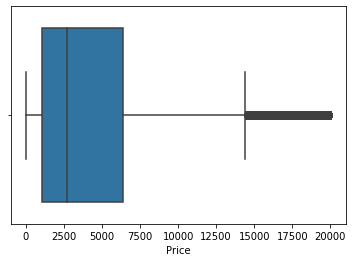

In [268]:
sns.boxplot(x=cars['Price'])
cars.Price.mean()

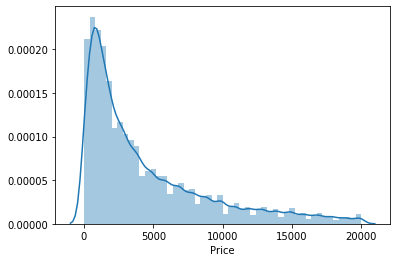

In [269]:
sns.distplot(cars['Price'])

In [270]:
part_of_value(df1 = cars.query('Price<100'),
              df=cars)

3.751308907912154

таких данных более 3%. Будем считать это ошибкой ввода поэтому удаляем.

In [271]:
cars = cars.drop(cars.query('Price<100').index)
cars.shape

(341012, 16)

<div class="alert alert-block alert-info">
<b>Совет:</b> Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Поэтому я тоже все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div> 

#### Работа с пропусками

In [272]:
pass_value(cars)

DateCrawled           0.000000
Price                 0.000000
VehicleType           9.550690
RegistrationYear      0.000000
Gearbox               4.773439
Power                 0.000000
Model                 4.988681
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              8.303227
Brand                 0.000000
NotRepaired          18.862386
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

по категориальным признакам имеем пропуски 5-10% , по признаку ремонт 19,2%

Посмотрим на распределение данных в признаках.

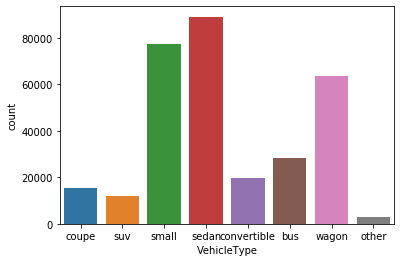

In [273]:
sns.countplot(cars.VehicleType)

Распраделение по моделям походим на реальность, если имееть ввиду, что это данные по Европе и Америке.

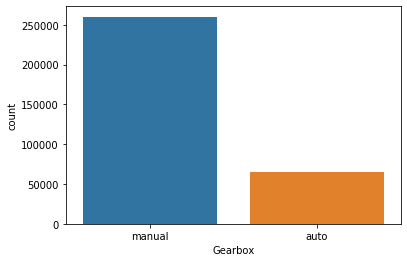

In [274]:
sns.countplot(cars.Gearbox)

Коробка передач в основном ручная, что тоже похоже на европейцев.

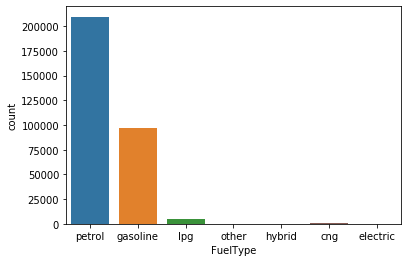

In [275]:
sns.countplot(cars.FuelType)

В английском есть petrol , в американском английском gasoline. Приравняем эти значения. 

In [276]:
cars.FuelType = cars.FuelType.replace('gasoline', 'petrol')

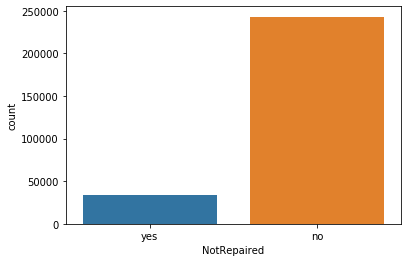

In [277]:
sns.countplot(cars.NotRepaired)

Заменим пропуски в категории NotRepaired на other

In [278]:
cars.NotRepaired = cars.NotRepaired.fillna('other')

категориальные признаки необходимо перевести в численные,это понадобится в будущем для построения модели.
для этого выделим индексы где есть пропуски, чтобы применить LabelEncoder.

In [279]:
# определим индексы с пропусками и без для столбцов.
VT_NAN_index = cars.query('VehicleType!=VehicleType')['VehicleType'].index
VT_index = cars.query('VehicleType==VehicleType')['VehicleType'].index

Gearbox_NAN_index = cars.query('Gearbox!=Gearbox')['Gearbox'].index
Gearbox_index = cars.query('Gearbox==Gearbox')['Gearbox'].index

Model_NAN_index = cars.query('Model!=Model')['Model'].index
Model_index = cars.query('Model==Model')['Model'].index

FuelType_NAN_index = cars.query('FuelType!=FuelType')['FuelType'].index
FuelType_index = cars.query('FuelType==FuelType')['FuelType'].index


Brand_NAN_index = cars.query('Brand!=Brand')['Brand'].index
Brand_index = cars.query('Brand==Brand')['Brand'].index


NotRepaired_NAN_index = cars.query('NotRepaired!=NotRepaired')['NotRepaired'].index
NotRepaired_index = cars.query('NotRepaired==NotRepaired')['NotRepaired'].index

Для дальнейшей работе по замене пропусков и выбросов перейдем к численным данным.  
Для это применим LabelEncoder

In [280]:
le = preprocessing.LabelEncoder()

In [281]:
cars.loc[VT_index,'VehicleType'] = le.fit_transform(cars.loc[VT_index,'VehicleType'])

cars.loc[Gearbox_index,'Gearbox'] = le.fit_transform(cars.loc[Gearbox_index,'Gearbox'])

cars.loc[Model_index,'Model'] = le.fit_transform(cars.loc[Model_index,'Model'])

cars.loc[FuelType_index,'FuelType'] = le.fit_transform(cars.loc[FuelType_index,'FuelType'])

cars.loc[Brand_index,'Brand'] = le.fit_transform(cars.loc[Brand_index,'Brand'])

cars.loc[NotRepaired_index,'NotRepaired'] = le.fit_transform(cars.loc[NotRepaired_index,'NotRepaired'])

cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,1,0,116,150000,0,5,38,1,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,2,2011,1,190,NaN,125000,5,5,1,2,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,6,2004,0,163,117,125000,8,5,14,1,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,5,2001,1,75,116,150000,6,5,38,0,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,5,2008,1,69,101,90000,7,5,31,0,2016-03-31,0,60437,2016-04-06 10:17:21


Сначал заполним пропуски в столбце "Model", далее заполним пропуски в остальных данных на основании столбца "Model".


In [282]:
pass_replace_3(df = cars ,col1 = 'Brand' ,col2 = 'Power',col3 = 'RegistrationYear',col = 'Model',index = Model_NAN_index)
pass_replace_3(df = cars ,col1 = 'Brand' ,col2 = 'Model',col3 = 'RegistrationYear',col = 'VehicleType',index = VT_NAN_index)
pass_replace_3(df = cars ,col1 = 'Brand' ,col2 = 'Model',col3 = 'RegistrationYear',col = 'Gearbox',index = Gearbox_NAN_index)
pass_replace_3(df = cars ,col1 = 'Brand' ,col2 = 'Model',col3 = 'RegistrationYear',col = 'FuelType',index = FuelType_NAN_index)

#pass_replace_3(df = cars ,col1 = 'Model' ,col2 = 'Kilometer',col3 = 'RegistrationYear',col = 'NotRepaired',index = NotRepaired_NAN_index)
pass_value(cars)

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



DateCrawled          0.000000
Price                0.000000
VehicleType          4.365829
RegistrationYear     0.000000
Gearbox              0.275943
Power                0.000000
Model                1.121368
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.402332
Brand                0.000000
NotRepaired          0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пропусков осталось не более 4,4 %.
Теперь заполним пропуски по 2 признакам

In [283]:
def pass_replace_2(df,col1,col2,col,index):
    '''
    функция заменяет в исходном df значения на медианные предварительно группируя по 2 параметрам
    '''
    tmp = df.groupby([col1,col2])[col].apply(lambda x: x.fillna(x.median()))
    df.loc[index,col] = tmp[index]
    return df

In [284]:
pass_replace_2(df = cars ,col1 = 'Brand' ,col2 = 'RegistrationYear',col = 'Model',index = Model_NAN_index)
pass_replace_2(df = cars ,col1 = 'Brand' ,col2 = 'Model',col = 'VehicleType',index = VT_NAN_index)
pass_replace_2(df = cars ,col1 = 'Model' ,col2 = 'RegistrationYear',col = 'Gearbox',index = Gearbox_NAN_index)
pass_replace_2(df = cars ,col1 = 'Model' ,col2 = 'RegistrationYear',col = 'FuelType',index = FuelType_NAN_index)
#pass_replace_2(df = cars ,col1 = 'Model' ,col2 = 'Kilometer',col = 'NotRepaired',index = NotRepaired_NAN_index)

pass_value(cars)

DateCrawled          0.000000
Price                0.000000
VehicleType          0.183864
RegistrationYear     0.000000
Gearbox              0.221107
Power                0.000000
Model                0.799679
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.267733
Brand                0.000000
NotRepaired          0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пропусков осталось не более 0,8 %. Пока не удаляем. Вернемся после чистки по другим колонкам.

#### Работа с выбросами

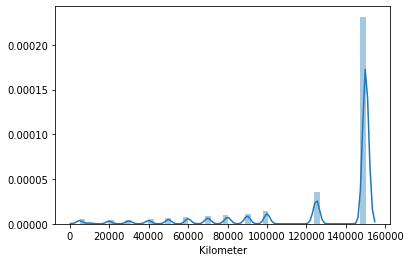

In [285]:
sns.distplot(cars.Kilometer)


Пробег большинства авто около 150000 км. Странно , что максимальный пробег = 150000, возможно это ограничение сервиса.
Не трогаем.

In [286]:
part_of_value(df1 = cars.query('RegistrationMonth==0'),
              df=cars)

9.266829319789332

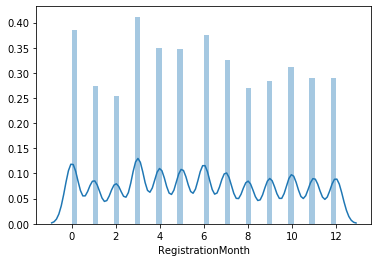

In [287]:
sns.distplot(cars.RegistrationMonth)

Более 9% значений месяца = 0, что много.  
При этом в 12 месяце значений около этой же величины, а в 1 месяце более чем в 2,5 раза меньше. 
Согласно статистике продажа авто имеет сезонность. Основная просадка приходится на январь, что совпадает с нашими данными:
![](https://pandia.ru/text/81/503/images/img57_7.png)
Т.е. в 1 месяце продажи обычно всегд низкие, поэтому предположить, что 0 можно заменить на 1 не правильно.



у нас получается 29437 записей где месяц регистрации = 0. 

In [288]:
cars.query('RegistrationMonth == 0').shape[0]

31601

 
распеределим эти записи пропорционально доли каждого месяца по соответсвтующим месяцам случайным образом.

In [298]:
frac_list = []
for i in range(1,13):
    '''
    создадим список с размерами "месяцев регистрации" относительно RegistrationMonth == 0 
    рассчитаем сколько записей из 0 месяца надо передать в каждый месяц
    '''
    frac = cars.query('RegistrationMonth==@i').shape[0]/(cars.shape[0]-cars.query('RegistrationMonth == 0').shape[0])
    n_size = round(cars.query('RegistrationMonth == 0').shape[0]*frac)
    frac_list.append(n_size)

In [299]:
# проверка окргуления
tmp = sum(frac_list)-cars.query('RegistrationMonth == 0').shape[0]
# вот такая дельта
tmp

-2

In [300]:
# округление дало сбой, поэтому добавим в 12 месяц + 1
frac_list[11] = frac_list[11]-tmp
sum(frac_list)-cars.query('RegistrationMonth == 0').shape[0]

0

In [301]:
all_idx = np.array(cars.query('RegistrationMonth==0').index)
for month,i in enumerate(frac_list):
    #print(all_idx.size)
    '''
    заменяем значения в столбце RegistrationMonth == 0  на номера месяцев с 1 по 12 пропорционально их доле
    
    '''
    idx = np.random.choice(all_idx, size=i,replace=False)
    cars.loc[idx,'RegistrationMonth'] = (month+1)
    all_idx = all_idx[~np.isin(all_idx, idx)]


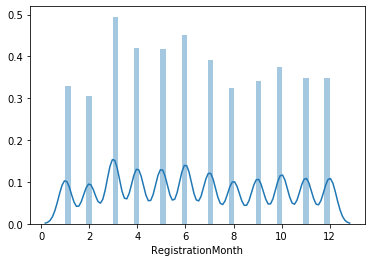

In [302]:
sns.distplot(cars.RegistrationMonth)

In [303]:
part_of_value(df1 = cars.query('RegistrationMonth==0'),
              df=cars)

0.0

Месяц == 0 отсутствует, значение перераспеределены.

**Мощность двигателя** не может быть более 1521 л.с.. согласно информации из интернета.

In [304]:
part_of_value(df1 = cars.query('Power>1521'),
              df=cars)

0.05190433181237024

Примерно 0,5% данных где мощнось двигателя превышает максимальную на 2016 год.  
Будем удалять.

In [305]:
cars = cars.drop(cars.query('Power>1521').index)

Теперь посмотрим на пропуски, которые остались ранее.  
Выполним удаление.

In [306]:
df_info(cars)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
Int64Index: 340835 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          340835 non-null datetime64[ns]
Price                340835 non-null int64
VehicleType          340208 non-null object
RegistrationYear     340835 non-null int64
Gearbox              340081 non-null object
Power                340835 non-null int64
Model                338109 non-null object
Kilometer            340835 non-null int64
RegistrationMonth    340835 non-null int64
FuelType             339923 non-null object
Brand                340835 non-null int64
NotRepaired          340835 non-null int64
DateCreated          340835 non-null datetime64[ns]
NumberOfPictures     340835 non-null int64
PostalCode           340835 non-null int64
LastSeen             340835 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(9), object(4)
memory usage: 44.2+ MB
+++++++++++++++++++

In [307]:
cars = cars.drop(cars.query('VehicleType!=VehicleType or Gearbox!=Gearbox or Model!=Model or FuelType!=FuelType').index)

In [308]:
df_info(cars)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
Int64Index: 337689 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          337689 non-null datetime64[ns]
Price                337689 non-null int64
VehicleType          337689 non-null object
RegistrationYear     337689 non-null int64
Gearbox              337689 non-null object
Power                337689 non-null int64
Model                337689 non-null object
Kilometer            337689 non-null int64
RegistrationMonth    337689 non-null int64
FuelType             337689 non-null object
Brand                337689 non-null int64
NotRepaired          337689 non-null int64
DateCreated          337689 non-null datetime64[ns]
NumberOfPictures     337689 non-null int64
PostalCode           337689 non-null int64
LastSeen             337689 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(9), object(4)
memory usage: 43.8+ MB
+++++++++++++++++++

Посмотрим строки где все данные дублируются.  
Т.к. кроме данных дублируется и время подачи, просмотра и создания, то это баг.  
Удаляем!

In [309]:
cars[cars.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,7,2001,1,131,170,150000,7,5,38,0,2016-03-18,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,2,1999,0,193,76,20000,7,5,20,0,2016-03-08,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,5,2002,1,83,166,150000,1,5,35,0,2016-03-28,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,2,1999,0,193,76,20000,7,5,20,0,2016-03-08,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,2,2003,0,218,76,125000,6,5,20,2,2016-04-03,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,5,2002,1,83,166,150000,1,5,35,0,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,2,2003,0,218,76,125000,6,5,20,2,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,7,2001,1,131,170,150000,7,5,38,0,2016-03-18,0,36391,2016-03-18 18:46:15


In [310]:
cars = cars.drop_duplicates()


Теперь удалим столбцы с типом данных datetime т.к. эти данные никак не влияют на работу модели.

In [311]:
cars = cars.drop(columns = ['DateCrawled','DateCreated','LastSeen'])

Заменим типы данных object на integer

In [312]:
cars = cars.astype({'VehicleType': 'int32',
            'Gearbox':'int32',
            'Model': 'int32',
            'FuelType': 'int32',
                   'NotRepaired':'int32'})

In [313]:
df_info(cars)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
Int64Index: 337685 entries, 0 to 354368
Data columns (total 13 columns):
Price                337685 non-null int64
VehicleType          337685 non-null int32
RegistrationYear     337685 non-null int64
Gearbox              337685 non-null int32
Power                337685 non-null int64
Model                337685 non-null int32
Kilometer            337685 non-null int64
RegistrationMonth    337685 non-null int64
FuelType             337685 non-null int32
Brand                337685 non-null int64
NotRepaired          337685 non-null int32
NumberOfPictures     337685 non-null int64
PostalCode           337685 non-null int64
dtypes: int32(5), int64(8)
memory usage: 29.6 MB
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Описание количественных переменных:
               Price    VehicleType  RegistrationYear        Gearbox  \
count  3376

In [314]:
#cars2 = cars2.drop(['NumberOfPictures',"DateCrawled", "DateCreated", "LastSeen"],axis = 1)
#cars2 = cars2.drop(cars.query('Price==0').index)
#cars2 = cars2.drop(cars2.query('VehicleType!=VehicleType or Gearbox!=Gearbox or Model!=Model or FuelType!=FuelType or NotRepaired!=NotRepaired').index)


#cars2.shape

In [315]:
#cars2.duplicated().sum()


In [316]:
#cars2 = cars2.drop_duplicates()
#cars2.shape

In [317]:
#cars2.head()

In [318]:
#cars2.VehicleType = le.fit_transform(cars2.VehicleType)
#cars2.Gearbox = le.fit_transform(cars2.Gearbox)
#cars2.Model = le.fit_transform(cars2.Model)
#cars2.FuelType = le.fit_transform(cars2.FuelType)
#cars2.Brand = le.fit_transform(cars2.Brand)
#cars2.NotRepaired = le.fit_transform(cars2.NotRepaired)

#cars2.head()

### Подитог:
- выполнили подготовку данных для построения модели: заменили выбросы, пропуски;
- пришлось удалить около 4% данных;
- в финальной версии таблице много дубликатов, но это фактически просто совпадение данных, поэтому оставляем;

Можно переходить к построению моделей.

## Обучение моделей

Делим на признаки и таргет:

In [319]:
X = cars.drop('Price',axis=1)
y = cars['Price']
#X = cars2.drop('Price',axis=1)
#y = cars2['Price']


In [320]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RNS)

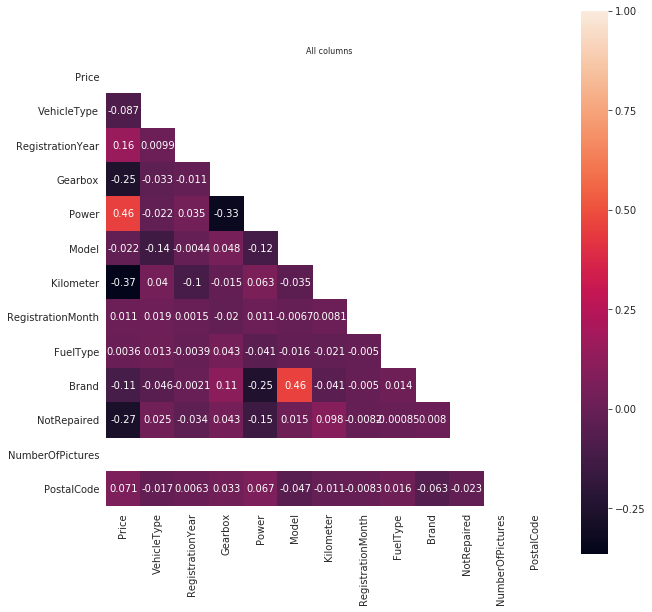

In [321]:
# матрица корреляций между признаками

corr_total = cars.corr()
#corr_total = cars2.corr()
mask = np.zeros_like(corr_total)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr_total, mask=mask, square=True,annot=True)
    plt.title("All columns", fontsize =8)

Видна высокая корреляция между моделью и брендом.
Но т.к. значения ниже 0,8 то оставляем  без изменений.

count    337685.000000
mean       4576.359282
std        4503.645358
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

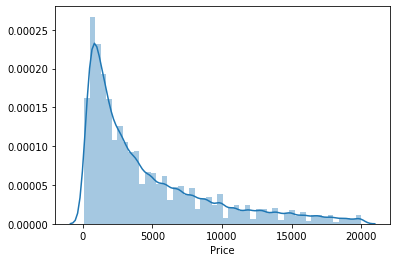

In [322]:
sns.distplot(y)
y.describe()

In [323]:
def learn_time(model,x_train,y_train):
    start = time.time()
    '''
    функция считает время на обучение модели
    '''
    model.fit(x_train,y_train)
    end = time.time()
    time_fit = end - start
    return time_fit,model

In [324]:
def predict_time(model,x_test):
    start = time.time()
    '''
    функция считает время на предсказания
    '''
    predict = model.predict(x_test)
    end = time.time()
    time_predict= end - start
    return time_predict,predict

In [325]:
# сюда будем складывать результаты
cars_result = pd.DataFrame(columns=['RMSE','Learning time','Predict time','Model'])
cars_result

,RMSE,Learning time,Predict time,Model


In [326]:
def cars_metrics(RMSE,l_time,p_time,model_name,df):
    '''
    функция добавит в результ. df: RMSE, время обучения и время предсказания
    
    '''
    df.loc[model_name,'RMSE'] = RMSE
    df.loc[model_name,'Learning time'] = l_time
    df.loc[model_name,'Predict time'] = p_time
    df.loc[model_name,'Model'] = model_name
    return df

В данном разделе выполним настройку различных моделей, при этом не будем изменять гиперпараметры, чтобы не нарушить чистоту эксперимента.


### Линейные модели:
#### Линейная регрессия

In [327]:
LR_learn_time,LR_model = learn_time(LinearRegression(),x_train,y_train)
LR_pred_time,LR_predict = predict_time(LR_model,x_test)
LR_RMSE = np.sqrt(mean_squared_error(y_test, LR_predict))
cars_metrics(LR_RMSE,LR_learn_time,LR_pred_time,'Linear regression',cars_result)

,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression


#### Ridge регрессия

In [328]:
Ridge_l_time,Ridge = learn_time(Ridge(alpha=1,random_state=RNS),x_train,y_train) #,
Ridge_p_time,Ridge_predict = predict_time(Ridge,x_test)
Ridge_RMSE = np.sqrt(mean_squared_error(y_test, Ridge_predict))
cars_metrics(Ridge_RMSE,Ridge_l_time,Ridge_p_time,'Ridge regression',cars_result)

,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression


#### Lasso регрессия

In [329]:
Lasso_l_time,Lasso = learn_time(Lasso(alpha=0.5,random_state=RNS),x_train,y_train)
Lasso_p_time,Lasso_predict = predict_time(Lasso,x_test)
Lasso_RMSE = np.sqrt(mean_squared_error(y_test, Lasso_predict))
cars_metrics(Lasso_RMSE,Lasso_l_time,Lasso_p_time,'Lasso regression',cars_result)

,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression


#### Подитог:
 - линейные модели ведут себя идентично,независимо от перебора коэфф. alpha. 

### Decision Tree

In [330]:
tree_l_time,tree = learn_time(DecisionTreeRegressor(),x_train,y_train)
tree_p_time,tree_predict = predict_time(tree,x_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, tree_predict))
cars_metrics(rmse_tree,tree_l_time,tree_p_time,'Decision Tree',cars_result)

,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree


дерево решений значительно лучше предсказывает чем линейные модели, но время обучения существенно подросло.

### Ансамблевые методы регрессии
#### Random forest regressor

In [331]:
RF_l_time,RF = learn_time(RandomForestRegressor(n_estimators=20,random_state=RNS),x_train,y_train)
RF_p_time,RF_predict = predict_time(RF,x_test)
RF_RMSE = np.sqrt(mean_squared_error(y_test, RF_predict))
cars_metrics(RF_RMSE,RF_l_time,RF_p_time,'Random Forest',cars_result)

,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree
Random Forest,1630.34,30.163,1.01492,Random Forest


#### GradientBoostingRegressor

In [332]:
gbr_l_time,gbr = learn_time(GradientBoostingRegressor(n_estimators=100,random_state=RNS),x_train,y_train)

gbr_p_time,gbr_predict = predict_time(gbr,x_test)
gbr_RMSE = np.sqrt(mean_squared_error(y_test, gbr_predict))
cars_metrics(gbr_RMSE,gbr_l_time,gbr_p_time,'GradientBoostingRegressor',cars_result)


,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree
Random Forest,1630.34,30.163,1.01492,Random Forest
GradientBoostingRegressor,1970.1,30.1025,0.201139,GradientBoostingRegressor


### Иттеративные модели
#### Lightgbm

In [333]:
lgb_l_time,lgb = learn_time(LGBMRegressor(random_state=RNS),x_train,y_train) #n_estimators=100

In [334]:
lgb_p_time,lgb_predict = predict_time(lgb,x_test)
lgb_RMSE = np.sqrt(mean_squared_error(y_test, lgb_predict))
cars_metrics(lgb_RMSE,lgb_l_time,lgb_p_time,'Lightgbm',cars_result)


,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree
Random Forest,1630.34,30.163,1.01492,Random Forest
GradientBoostingRegressor,1970.1,30.1025,0.201139,GradientBoostingRegressor
Lightgbm,1736.88,3.26275,0.746483,Lightgbm


#### XGBoost

In [335]:
xgbr_l_time,xgbr = learn_time(xgb.XGBRegressor(n_estimators=100,random_state=RNS),x_train,y_train)
xgbr_p_time,xgbr_predict = predict_time(xgbr,x_test)
xgbr_RMSE = np.sqrt(mean_squared_error(y_test, xgbr_predict))
cars_metrics(xgbr_RMSE,xgbr_l_time,xgbr_p_time,'XGBoost',cars_result)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[13:07:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree
Random Forest,1630.34,30.163,1.01492,Random Forest
GradientBoostingRegressor,1970.1,30.1025,0.201139,GradientBoostingRegressor
Lightgbm,1736.88,3.26275,0.746483,Lightgbm
XGBoost,1968.69,18.3398,0.340997,XGBoost


#### Catboost

In [336]:
cat_l_time,cat = learn_time(CatBoostRegressor(loss_function='RMSE', n_estimators=100, silent=True),x_train,y_train)
cat_p_time,cat_predict = predict_time(cat,x_test)
cat_RMSE = np.sqrt(mean_squared_error(y_test, cat_predict))
cars_metrics(cat_RMSE,cat_l_time,cat_p_time,'Catboost',cars_result)

,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree
Random Forest,1630.34,30.163,1.01492,Random Forest
GradientBoostingRegressor,1970.1,30.1025,0.201139,GradientBoostingRegressor
Lightgbm,1736.88,3.26275,0.746483,Lightgbm
XGBoost,1968.69,18.3398,0.340997,XGBoost
Catboost,2132.6,20.3845,0.0131304,Catboost


### Baseline
- модель для ориентира остальных моделей.

In [337]:
y_hat = y.copy()
y_hat.loc[:] = y.mean()
y_hat.head()

0    4576.359282
1    4576.359282
2    4576.359282
3    4576.359282
4    4576.359282
Name: Price, dtype: float64

In [338]:
base_RMSE = np.sqrt(mean_squared_error(y, y_hat))
cars_metrics(base_RMSE,0,0,'Baseline',cars_result)


,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree
Random Forest,1630.34,30.163,1.01492,Random Forest
GradientBoostingRegressor,1970.1,30.1025,0.201139,GradientBoostingRegressor
Lightgbm,1736.88,3.26275,0.746483,Lightgbm
XGBoost,1968.69,18.3398,0.340997,XGBoost
Catboost,2132.6,20.3845,0.0131304,Catboost
Baseline,4503.64,0,0,Baseline


### Подитог:
- получили результаты разных моделей , свели в сводную таблцу;
- очевидно, что все модели работают лучше базовой(baseline);
- очевидно, что модели с большим набором простых моделей внутри работают дольше.


Теперь перейдем к анализу моделей.

## Анализ моделей

In [339]:
cars_result

,RMSE,Learning time,Predict time,Model
Linear regression,3408.37,0.118347,0.111683,Linear regression
Ridge regression,3408.37,0.0421576,0.00619817,Ridge regression
Lasso regression,3408.36,0.316746,0.0056622,Lasso regression
Decision Tree,2147.31,3.00886,0.0711076,Decision Tree
Random Forest,1630.34,30.163,1.01492,Random Forest
GradientBoostingRegressor,1970.1,30.1025,0.201139,GradientBoostingRegressor
Lightgbm,1736.88,3.26275,0.746483,Lightgbm
XGBoost,1968.69,18.3398,0.340997,XGBoost
Catboost,2132.6,20.3845,0.0131304,Catboost
Baseline,4503.64,0,0,Baseline


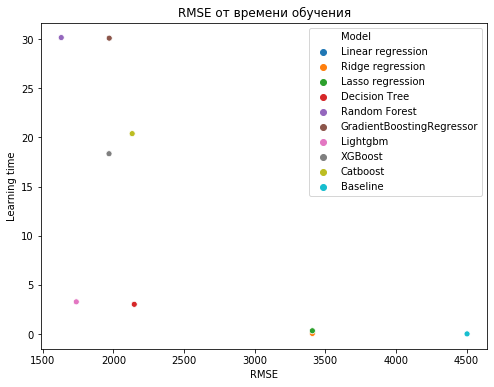

In [340]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = cars_result ,x ='RMSE', y='Learning time', hue="Model")
plt.title('RMSE от времени обучения')
plt.show()

Видно что чем ниже RMSE, тем дольше время обучения модели.  
Лучше всех в этом плане показывается себя модель LightGBM

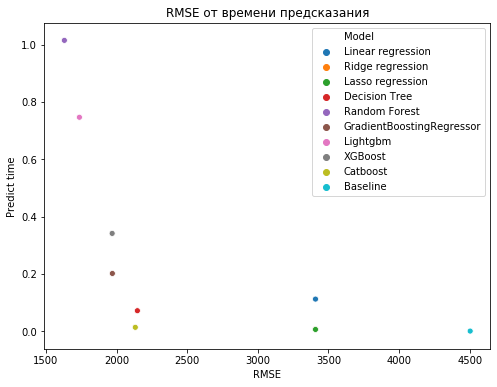

In [341]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = cars_result ,x ='RMSE', y='Predict time', hue="Model")
plt.title('RMSE от времени предсказания')
plt.show()

Аналогично времени обучения - чем ниже RMSE, тем дольше время предсказания модели.
Лучше всех в этом плане показывается себя модель LightGBM

#### Настройка модели LGBMRegressor

In [342]:
def get_est():
    '''
    функция создает модель LGBMRegressor с разным количеством деревьев
    '''
    models = dict()
    trees = [10, 50, 100, 500, 1000]
    for n in trees:
        models[n] = LGBMRegressor(n_estimators=n,random_state=RNS)
    return models

lgbmr = get_est()

In [343]:
def get_depth():
    '''
    функция создает модель LGBMRegressor с разной глубиной дерева и количеством листьев
    '''
    models = dict()
    for i in  range(1,11):
        models[i] = LGBMRegressor(max_depth=i,num_leaves=2**i,random_state=RNS)
    return models

lgbm_i = get_depth()

In [344]:
def get_l_rate():
    '''
    функция создает модель LGBMRegressor с разной скоростью обучения
    '''
    models = dict()
    learn_rate = [0.01,0.1,0.3,0.8]
    for i in  learn_rate:
        models[i] = LGBMRegressor(learning_rate=i,random_state=RNS)
    return models

lgbm_l = get_l_rate()




In [351]:
# высчиатем время обучения, RMSE  в зависимости от количества деревьев в модели
# добавим все результаты в новый датафрейм
lgbl_df = pd.DataFrame()
for name, model in lgbm_l.items():
    s = time.time()
    model.fit(x_train,y_train)
    e = time.time()
    l_time = e-s
    predict = model.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test, predict))
    lgbl_df.loc[name,'RMSE'] = RMSE
    lgbl_df.loc[name,'Learning time'] = l_time
    lgbl_df.loc[name,'Learning_rate'] = name

In [352]:
lgbl_df
        
    

,RMSE,Learning time,Learning_rate
0.01,2680.221797,4.857496,0.01
0.10,1736.881283,4.101027,0.10
0.30,1663.198766,3.269681,0.30
0.80,1692.577292,2.973154,0.80


In [353]:
# высчиатем время обучения, RMSE  в зависимости от количества деревьев в модели
# добавим все результаты в новый датафрейм
lgbm_df = pd.DataFrame()
for name, model in lgbmr.items():
    s = time.time()
    model.fit(x_train,y_train)
    e = time.time()
    l_time = e-s
    predict = model.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test, predict))
    lgbm_df.loc[name,'RMSE'] = RMSE
    lgbm_df.loc[name,'Learning time'] = l_time
    lgbm_df.loc[name,'Trees'] = name

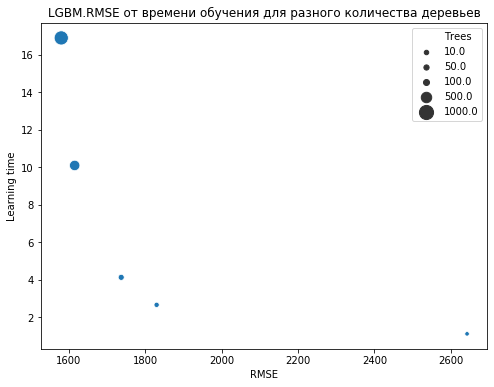

In [354]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = lgbm_df ,x ='RMSE', y='Learning time',size="Trees",sizes=(20, 200),legend="full")
plt.title('LGBM.RMSE от времени обучения для разного количества деревьев')
plt.show()

In [355]:
lgbm_df

,RMSE,Learning time,Trees
10,2642.519499,1.105804,10.0
50,1829.616790,2.652656,50.0
100,1736.881283,4.119798,100.0
500,1615.004187,10.088531,500.0
1000,1579.865497,16.893057,1000.0


In [356]:
# высчиатем время обучения, RMSE  в зависимости от глубины дерева в модели
# добавим все результаты в новый датафрейм
lgbi_df = pd.DataFrame()
for name, model in lgbm_i.items():
    s = time.time()
    model.fit(x_train,y_train)
    e = time.time()
    l_time = e-s
    predict = model.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test, predict))
    lgbi_df.loc[name,'RMSE'] = RMSE
    lgbi_df.loc[name,'Learning time'] = l_time
    lgbi_df.loc[name,'Max depth'] = name

In [357]:
lgbi_df

,RMSE,Learning time,Max depth
1,2539.244704,1.492103,1.0
2,2121.743901,1.727654,2.0
3,1967.166316,2.049096,3.0
4,1853.583309,2.444205,4.0
5,1786.626887,3.159737,5.0
6,1730.264538,3.307315,6.0
7,1683.331646,3.838637,7.0
8,1646.112693,4.635195,8.0
9,1620.684408,5.166945,9.0
10,1599.822638,6.169583,10.0


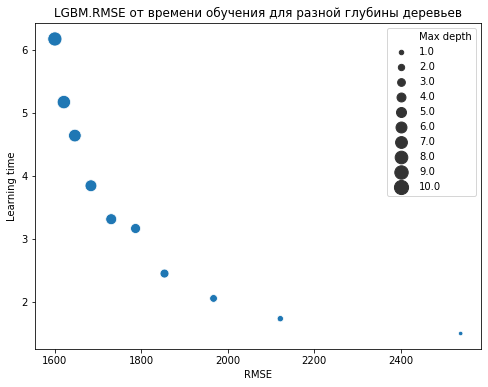

In [358]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = lgbi_df ,x ='RMSE', y='Learning time',size="Max depth",sizes=(20, 200),legend="full")
plt.title('LGBM.RMSE от времени обучения для разной глубины деревьев')
plt.show()

In [359]:
models = dict()
trees = [10, 100, 500, 1000]
learn_rate = [0.05,0.1,0.3]
max_depth = [2,3,5]
for n in trees:
    for i in learn_rate:
        for j in max_depth:
            models[str(n)+'_'+str(i)+'_'+str(j)] = LGBMRegressor(n_estimators=n,learning_rate=i,max_depth = j,random_state=RNS)


In [360]:
lgb_best_df = pd.DataFrame()
for name, model in models.items():
    s = time.time()
    model.fit(x_train,y_train)
    e = time.time()
    l_time = e-s
    predict = model.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test, predict))
    lgb_best_df.loc[name,'RMSE'] = RMSE
    lgb_best_df.loc[name,'Learning time'] = l_time


Предположим что лучшая модель LGBMRegressor имеет следующием параметры:

In [361]:
lgb_best_df.sort_values(by='RMSE').head()

,RMSE,Learning time
1000_0.3_5,1590.878198,19.673752
500_0.3_5,1606.950249,10.243951
1000_0.1_5,1610.115069,20.270917
500_0.1_5,1644.136986,10.979268
1000_0.05_5,1644.626532,20.974264


In [362]:
best_model = LGBMRegressor(n_estimators=1000,max_depth=5,learning_rate = 0.3,random_state=RNS)


Обучим и посмотри результаты

In [363]:
s = time.time()
best_model.fit(x_train,y_train)
e = time.time()
l_time = e-s
l_time

20.498191356658936

In [364]:
s = time.time()
RMSE = np.sqrt(mean_squared_error(y_test, best_model.predict(x_test)))
e = time.time()
p_time = e-s
print('время обучения=',l_time,'время предсказания=',p_time,'RMSE = ',RMSE)

время обучения= 20.498191356658936 время предсказания= 8.494276762008667 RMSE =  1590.8781982770463


### Вывод:
 

- Выполнена подготовка данных и обучение разных типов моделей регрессии
- линейные модели показали себя хуже остальных
- остальные модели имеют более менее схожую метрику RMSE без дополнительных настроек ( диапазон от 1641 до 2166 );
- при этом время обучения и время предсказаний для этих моделей существенно отличается (диапазон от 2-3 сек (Decision Tree, LightGBm) до 30 сек (Random Forest);
- аналогично и для времение предсказания (диапазон от 0.009 (CatBoost) до 1.06 (Random Forest))


Если усредниться до из "коробки" лучше всех работает модель регрессии из библиотеки LightGBm.

Настройка модели показала, что при переборе гиперпараметров удается улучшить RMSE , но при этом приходится жертвовать временем предсказания и обучения.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей